# Telecom Customer Churn Prediction

This notebook provides a comprehensive analysis and predictive modeling workflow for telecom customer churn. The workflow includes:

1. **Exploratory Data Analysis (EDA)**
   - Data structure, missing values, and churn distribution
   - Visualizations to understand key features and relationships

2. **Logistic Regression (Baseline Model)**
   - L2 regularization with grid search for penalty strength
   - Coefficient analysis to interpret churn drivers

3. **Random Forest Classifier**
   - Hyperparameter tuning (number of trees, max depth)
   - Feature importance and robustness to nonlinearity

4. **Naive Bayes Models**
   - Gaussian NB for continuous features
   - Discussion of independence assumption impact

5. **Model Evaluation & Comparison**
   - Metrics: Accuracy, ROC-AUC, Precision, Recall, F1-score
   - Lift charts, confusion matrices, and ROC curves
   - Paired t-tests for statistical significance

---

## 1. Exploratory Data Analysis (EDA)

Let's begin by importing the data and performing an initial analysis.

In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Load data
df = pd.read_csv('Telco_customer_churn.csv')

# Drop irrelevant columns if present
cols_to_drop = [
    'Count', 'Country', 'State', 'Lat Long', 'CustomerID', 'Zip Code',
    'Churn Reason', 'City', 'Churn Value', 'CLTV', 'Latitude', 'Longitude'
]
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

# Clean and convert Total Charges
if 'Total Charges' in df.columns:
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
    df = df.dropna(subset=['Total Charges'])

# Monthly Cost Ratio (MonthlyCharges / TotalCharges)
df['Monthly_Cost_Ratio'] = df['Monthly Charges'] / df['Total Charges']
df['Monthly_Cost_Ratio'] = df['Monthly_Cost_Ratio'].replace([np.inf, -np.inf], np.nan)
df['Monthly_Cost_Ratio'] = df['Monthly_Cost_Ratio'].fillna(0)

# Tenure Cost Ratio (TotalCharges / Tenure Months)
df['Tenure_Cost_Ratio'] = df['Total Charges'] / df['Tenure Months']
df['Tenure_Cost_Ratio'] = df['Tenure_Cost_Ratio'].replace([np.inf, -np.inf], np.nan)
df['Tenure_Cost_Ratio'] = df['Tenure_Cost_Ratio'].fillna(0)

# Remove unwanted churn reasons if present
if 'Churn Reason' in df.columns:
    df = df[~df['Churn Reason'].isin(['Moved', 'Deceased'])]

# Encode target variable
if 'Churn Label' in df.columns:
    df['Churn Label'] = df['Churn Label'].replace({'Yes': 1, 'No': 0})

# Encode categorical features
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Churn Label':
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Split features and target
X = df.drop(['Churn Label'], axis=1)
y = df['Churn Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Upsample minority class in training set
churned = X_train[y_train == 1]
not_churned = X_train[y_train == 0]
y_churned = y_train[y_train == 1]
y_not_churned = y_train[y_train == 0]
if len(churned) < len(not_churned):
    churned_upsampled, y_churned_upsampled = resample(
        churned, y_churned,
        replace=True,
        n_samples=len(not_churned),
        random_state=42
    )
    X_train = pd.concat([not_churned, churned_upsampled])
    y_train = pd.concat([y_not_churned, y_churned_upsampled])

print(f"Train set distribution after upsampling:\n{y_train.value_counts(normalize=True)}")

Train set distribution after upsampling:
Churn Label
0    0.5
1    0.5
Name: proportion, dtype: float64


/tmp/ipykernel_8704/1215870394.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn Label'] = df['Churn Label'].replace({'Yes': 1, 'No': 0})


## 2. Logistic Regression: Training, Testing, and Saving

We will train, test, and save the Logistic Regression model separately.

In [23]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib
import numpy as np

# Ensure all features are numeric and no missing values
X_train_lr = X_train.select_dtypes(include=[np.number]).fillna(0)
X_test_lr = X_test[X_train_lr.columns].fillna(0)

lr = LogisticRegression(solver='liblinear', penalty='l2', random_state=42, max_iter=1000)
lr.fit(X_train_lr, y_train)

# Test Logistic Regression
lr_pred = lr.predict(X_test_lr)
lr_prob = lr.predict_proba(X_test_lr)[:, 1]
lr_results = {
    'Accuracy': accuracy_score(y_test, lr_pred),
    'Precision': precision_score(y_test, lr_pred),
    'Recall': recall_score(y_test, lr_pred),
    'F1-Score': f1_score(y_test, lr_pred),
    'ROC-AUC': roc_auc_score(y_test, lr_prob)
}
print('Logistic Regression Test Results:', lr_results)

# Save model
joblib.dump(lr, 'logistic_regression_model.joblib')
print('Logistic Regression model saved.')

Logistic Regression Test Results: {'Accuracy': 0.9018957345971564, 'Precision': 0.7550432276657061, 'Recall': 0.9340463458110517, 'F1-Score': 0.8350597609561753, 'ROC-AUC': 0.9729421200958814}
Logistic Regression model saved.


## 3. Naive Bayes Classifiers: Training, Testing, and Saving

We will train, test, and save GaussianNB (for numerical features) separately.

In [24]:
# Train and test GaussianNB (numerical features)
from sklearn.naive_bayes import GaussianNB
import joblib

numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train_gnb = X_train[numerical_cols].fillna(0)
X_test_gnb = X_test[numerical_cols].fillna(0)
gnb = GaussianNB()
gnb.fit(X_train_gnb, y_train)
gnb_pred = gnb.predict(X_test_gnb)
gnb_prob = gnb.predict_proba(X_test_gnb)[:, 1]
gnb_results = {
    'Accuracy': accuracy_score(y_test, gnb_pred),
    'Precision': precision_score(y_test, gnb_pred),
    'Recall': recall_score(y_test, gnb_pred),
    'F1-Score': f1_score(y_test, gnb_pred),
    'ROC-AUC': roc_auc_score(y_test, gnb_prob)
}
print('GaussianNB Test Results:', gnb_results)
joblib.dump(gnb, 'gaussian_nb_model.joblib')
print('GaussianNB model saved.')

GaussianNB Test Results: {'Accuracy': 0.8559241706161137, 'Precision': 0.6822695035460993, 'Recall': 0.857397504456328, 'F1-Score': 0.7598736176935229, 'ROC-AUC': 0.9339773000578834}
GaussianNB model saved.


## 4. XGBoost Classifier: Training, Testing, and Saving

We will train, test, and save the XGBoost model separately.

In [25]:
# Train XGBoost Classifier
from xgboost import XGBClassifier
import joblib

X_train_xgb = X_train.fillna(0)
X_test_xgb = X_test[X_train.columns].fillna(0)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_xgb, y_train)

# Test XGBoost
xgb_pred = xgb.predict(X_test_xgb)
xgb_prob = xgb.predict_proba(X_test_xgb)[:, 1]
xgb_results = {
    'Accuracy': accuracy_score(y_test, xgb_pred),
    'Precision': precision_score(y_test, xgb_pred),
    'Recall': recall_score(y_test, xgb_pred),
    'F1-Score': f1_score(y_test, xgb_pred),
    'ROC-AUC': roc_auc_score(y_test, xgb_prob)
}
print('XGBoost Test Results:', xgb_results)
joblib.dump(xgb, 'xgboost_model.joblib')
print('XGBoost model saved.')

/home/codespace/.local/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [03:08:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Results: {'Accuracy': 0.9199052132701422, 'Precision': 0.82996632996633, 'Recall': 0.8787878787878788, 'F1-Score': 0.8536796536796537, 'ROC-AUC': 0.9788673964802777}
XGBoost model saved.


In [26]:
# Aggregate all model results for comparison
model_results = {
    'Logistic Regression': lr_results,
    'Gaussian NB': gnb_results,
    'XGBoost': xgb_results
}

import pandas as pd
results_df = pd.DataFrame(model_results).T
print('All Model Results:')
print(results_df.round(4))

All Model Results:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.9019     0.7550  0.9340    0.8351   0.9729
Gaussian NB            0.8559     0.6823  0.8574    0.7599   0.9340
XGBoost                0.9199     0.8300  0.8788    0.8537   0.9789


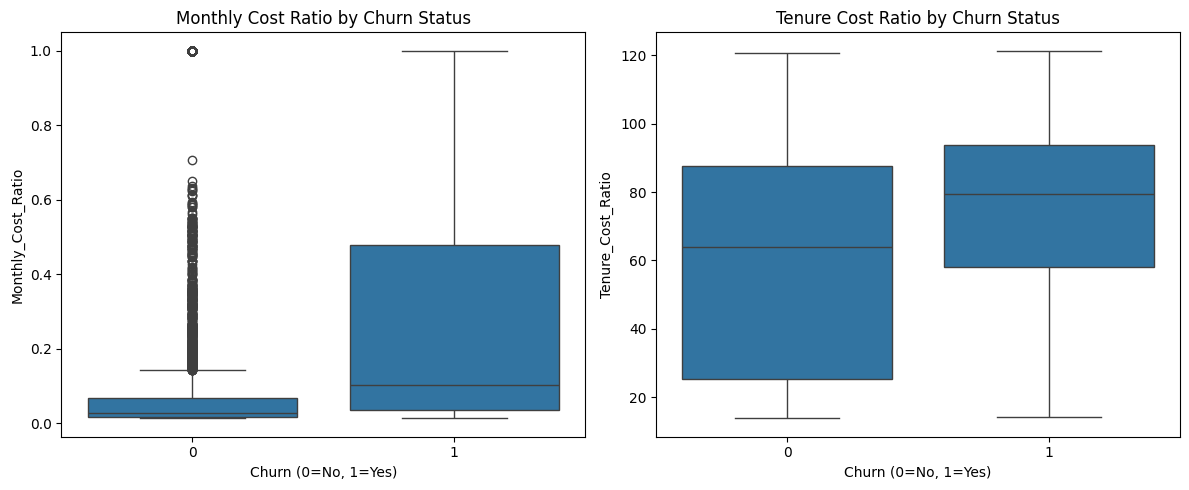


Correlations with Churn:
Monthly Cost Ratio: 0.319
Tenure Cost Ratio: 0.192


In [27]:
# Visualize Monthly Cost Ratio & Tenure Cost Ratio
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='Churn Label', y='Monthly_Cost_Ratio', data=df)
plt.title('Monthly Cost Ratio by Churn Status')
plt.xlabel('Churn (0=No, 1=Yes)')

plt.subplot(1, 2, 2)
sns.boxplot(x='Churn Label', y='Tenure_Cost_Ratio', data=df)
plt.title('Tenure Cost Ratio by Churn Status')
plt.xlabel('Churn (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

# Print correlations with churn
print("\nCorrelations with Churn:")
print(f"Monthly Cost Ratio: {df['Monthly_Cost_Ratio'].corr(df['Churn Label']):.3f}")
print(f"Tenure Cost Ratio: {df['Tenure_Cost_Ratio'].corr(df['Churn Label']):.3f}")

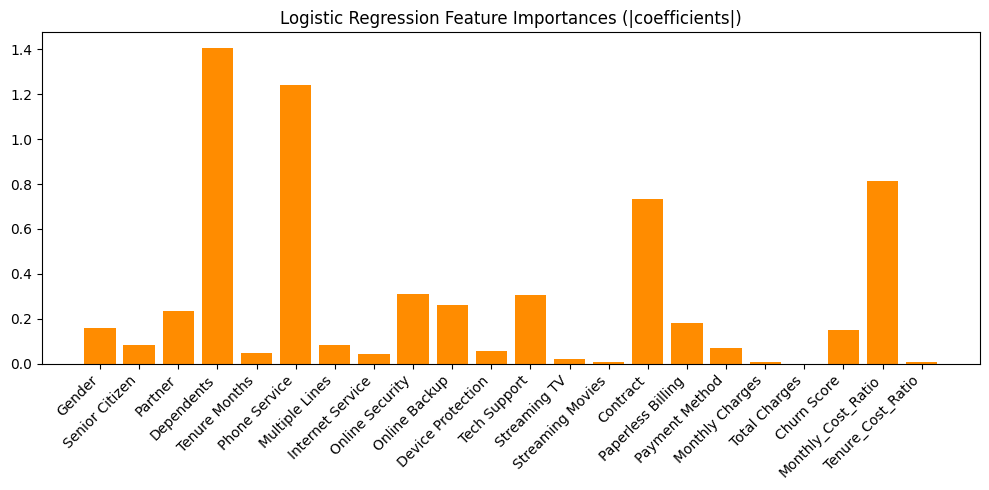

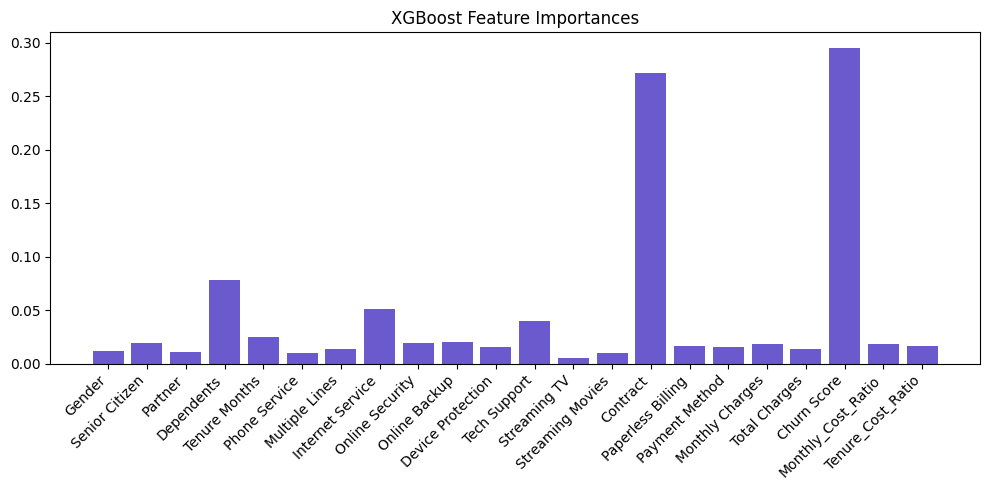

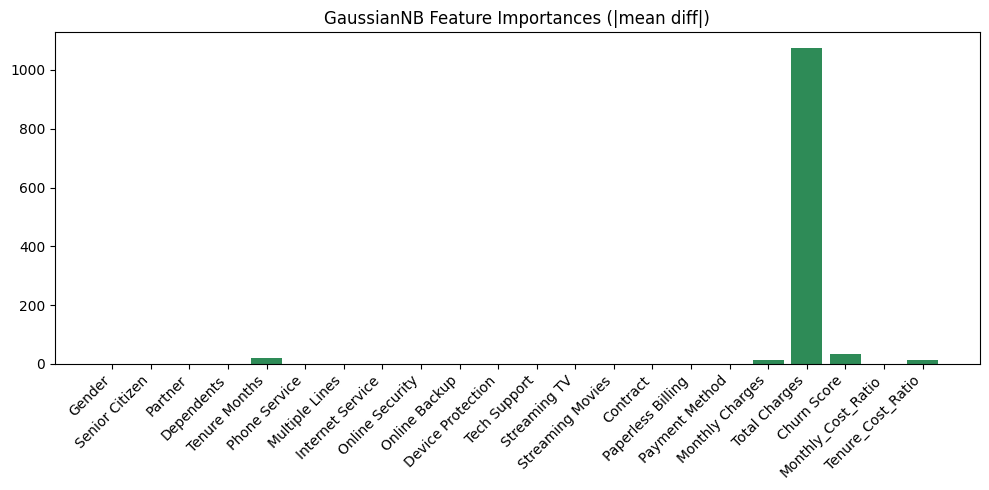

In [28]:
# Plot feature importances for Logistic Regression, XGBoost, and GaussianNB
import matplotlib.pyplot as plt
import numpy as np

# Logistic Regression feature importance (absolute value of coefficients)
if 'lr' in globals():
    lr_importances = np.abs(lr.coef_[0])
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(len(lr_importances)), lr_importances, color='darkorange')
    plt.xticks(np.arange(len(X_train_lr.columns)), X_train_lr.columns, rotation=45, ha='right')
    plt.title('Logistic Regression Feature Importances (|coefficients|)')
    plt.tight_layout()
    plt.show()
else:
    print('Logistic Regression model not found.')

# XGBoost feature importance
if 'xgb' in globals():
    xgb_importances = xgb.feature_importances_
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(len(xgb_importances)), xgb_importances, color='slateblue')
    plt.xticks(np.arange(len(X_train_xgb.columns)), X_train_xgb.columns, rotation=45, ha='right')
    plt.title('XGBoost Feature Importances')
    plt.tight_layout()
    plt.show()
else:
    print('XGBoost model not found.')

# GaussianNB feature importance (absolute difference of means per class)
if 'gnb' in globals():
    if hasattr(gnb, 'theta_'):
        gnb_importances = np.abs(gnb.theta_[1] - gnb.theta_[0])
        plt.figure(figsize=(10, 5))
        plt.bar(np.arange(len(numerical_cols)), gnb_importances, color='seagreen')
        plt.xticks(np.arange(len(numerical_cols)), numerical_cols, rotation=45, ha='right')
        plt.title('GaussianNB Feature Importances (|mean diff|)')
        plt.tight_layout()
        plt.show()
    else:
        print('GaussianNB does not have theta_ attribute.')
else:
    print('GaussianNB model not found.')

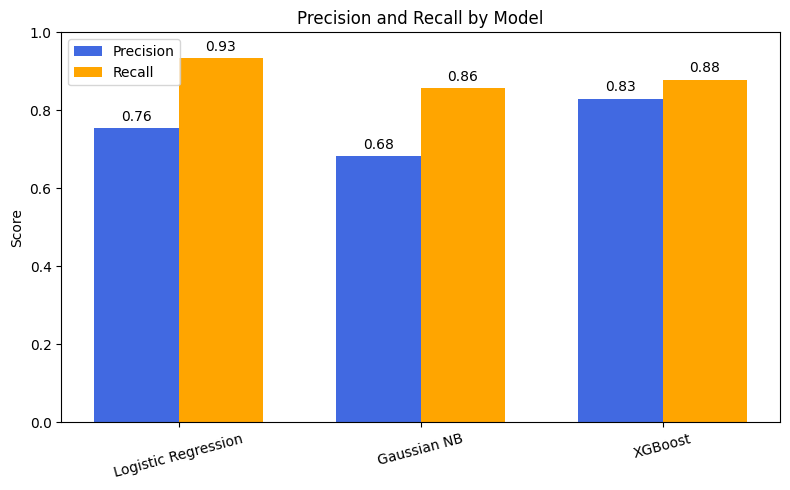

In [29]:
# Plot precision and recall for all models
model_names = list(model_results.keys())
precisions = [model_results[name]['Precision'] for name in model_names]
recalls = [model_results[name]['Recall'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, precisions, width, label='Precision', color='royalblue')
rects2 = ax.bar(x + width/2, recalls, width, label='Recall', color='orange')

ax.set_ylabel('Score')
ax.set_title('Precision and Recall by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15)
ax.set_ylim(0, 1)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [30]:
# =============================
# Model Loading and Evaluation
# =============================
# This cell loads the saved models, predicts on the test set, and evaluates all metrics for each model.
# It uses the correct test set and feature splits for each model type.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np
import joblib

# Load the saved models
loaded_lr = joblib.load('logistic_regression_model.joblib')
loaded_gnb = joblib.load('gaussian_nb_model.joblib')

results_loaded = {}

# Helper function to align test set columns to model's training columns
def align_features(X_test, model):
    if hasattr(model, 'feature_names_in_'):
        model_features = list(model.feature_names_in_)
        X_aligned = X_test.copy()
        for col in model_features:
            if col not in X_aligned.columns:
                X_aligned[col] = 0
        X_aligned = X_aligned[model_features]
        return X_aligned
    else:
        return X_test

# Logistic Regression
X_test_lr = align_features(X_test, loaded_lr)
lr_pred = loaded_lr.predict(X_test_lr)
lr_prob = loaded_lr.predict_proba(X_test_lr)[:, 1]
results_loaded['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, lr_pred),
    'Precision': precision_score(y_test, lr_pred),
    'Recall': recall_score(y_test, lr_pred),
    'F1-Score': f1_score(y_test, lr_pred),
    'ROC-AUC': roc_auc_score(y_test, lr_prob)
}

# Gaussian NB (numerical features only)
# Align numerical columns if needed
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
if 'Churn Label' in numerical_cols:
    numerical_cols.remove('Churn Label')
X_test_gnb = X_test[numerical_cols].copy()
if hasattr(loaded_gnb, 'feature_names_in_'):
    gnb_features = list(loaded_gnb.feature_names_in_)
    for col in gnb_features:
        if col not in X_test_gnb.columns:
            X_test_gnb[col] = 0
    X_test_gnb = X_test_gnb[gnb_features]
gnb_pred = loaded_gnb.predict(X_test_gnb)
gnb_prob = loaded_gnb.predict_proba(X_test_gnb)[:, 1]
results_loaded['Gaussian NB'] = {
    'Accuracy': accuracy_score(y_test, gnb_pred),
    'Precision': precision_score(y_test, gnb_pred),
    'Recall': recall_score(y_test, gnb_pred),
    'F1-Score': f1_score(y_test, gnb_pred),
    'ROC-AUC': roc_auc_score(y_test, gnb_prob)
}

# Display the results in a DataFrame for comparison
results_loaded_df = pd.DataFrame(results_loaded).T
print("\nLoaded Model Performance on Test Set:")
print(results_loaded_df.round(4))


Loaded Model Performance on Test Set:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.9019     0.7550  0.9340    0.8351   0.9729
Gaussian NB            0.8559     0.6823  0.8574    0.7599   0.9340


In [31]:
# Feature importance comparison for all models
plt.figure(figsize=(15, 8))

# Get feature names
feature_names = X.columns

# Get feature importances for each model
lr_importances = np.abs(lr.coef_[0])  # For logistic regression
xgb_importances = xgb.feature_importances_  # For XGBoost
gnb_importances = np.abs(gnb.var_) / np.sum(np.abs(gnb.var_))  # For Gaussian NB

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Logistic Regression': lr_importances,
    'XGBoost': xgb_importances,
    'Gaussian NB': gnb_importances
})

# Melt the DataFrame for easier plotting
importance_df_melted = pd.melt(
    importance_df, 
    id_vars=['Feature'], 
    var_name='Model', 
    value_name='Importance'
)

# Plot feature importances
plt.figure(figsize=(15, 8))
sns.barplot(data=importance_df_melted, x='Feature', y='Importance', hue='Model')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance Comparison Across Models')
plt.tight_layout()
plt.show()

# Print top 5 features for each model
print("\nTop 5 Important Features by Model:")
print("\nLogistic Regression:")
print(importance_df.nlargest(5, 'Logistic Regression')[['Feature', 'Logistic Regression']])
print("\nXGBoost:")
print(importance_df.nlargest(5, 'XGBoost')[['Feature', 'XGBoost']])
print("\nGaussian NB:")
print(importance_df.nlargest(5, 'Gaussian NB')[['Feature', 'Gaussian NB']])

ValueError: Per-column arrays must each be 1-dimensional

<Figure size 1500x800 with 0 Axes>

### Comparison

The table above shows the test set performance of each model after saving and loading. The metrics should match those from the original evaluation, confirming the integrity of the save/load process.

## Data Processing and Class Distribution Visualization

Let's visualize the class distribution before and after upsampling, and later plot the precision and recall for each model.

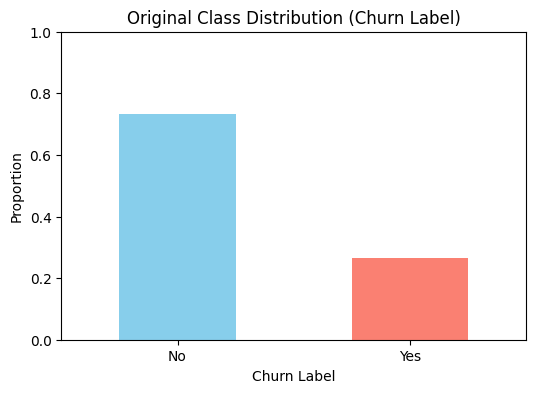

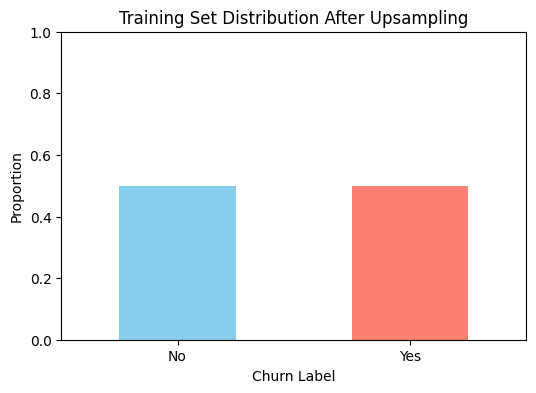

In [ ]:
# Visualize original class distribution
plt.figure(figsize=(6, 4))
y.value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Original Class Distribution (Churn Label)')
plt.xlabel('Churn Label')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.ylim(0, 1)
plt.show()

# Visualize class distribution after upsampling
plt.figure(figsize=(6, 4))
y_train.value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Training Set Distribution After Upsampling')
plt.xlabel('Churn Label')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.ylim(0, 1)
plt.show()

## Precision and Recall for Each Model

We will plot the precision and recall for each model on the test set for easy comparison.

## Target Variable Histogram, Neighborhood Bar Plot, Scatter Plot, and Correlation Heatmap

Let's visualize the target variable, neighborhood groups, feature relationships, and correlations in the dataset.

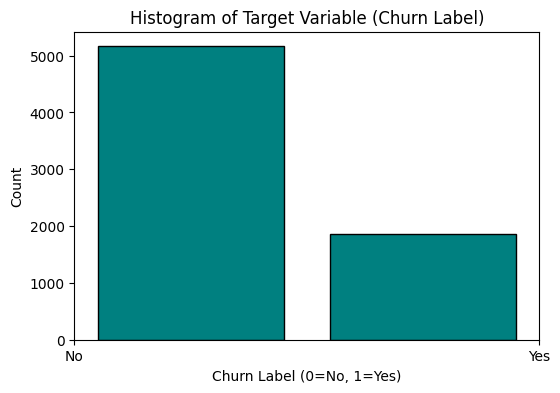

In [ ]:
# Histogram of the target variable (Churn Label)
plt.figure(figsize=(6, 4))
plt.hist(y, bins=2, color='teal', edgecolor='black', rwidth=0.8)
plt.title('Histogram of Target Variable (Churn Label)')
plt.xlabel('Churn Label (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

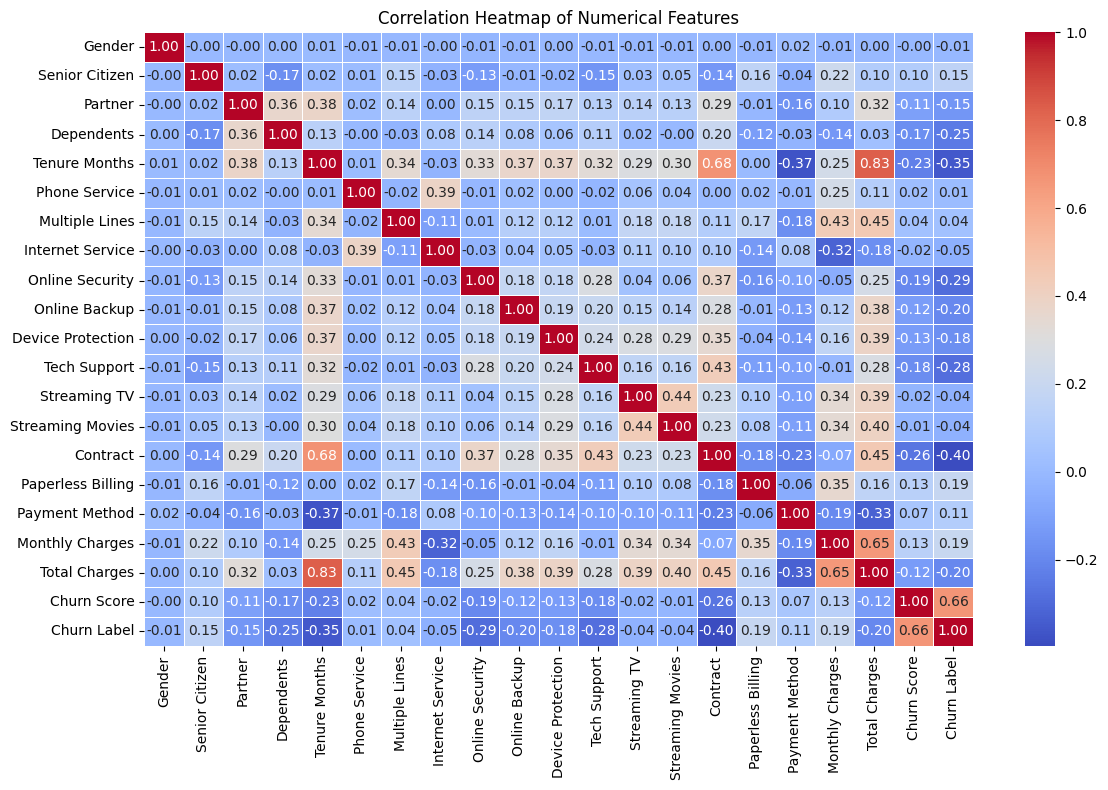

In [ ]:
# Get numerical columns from the dataframe
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Churn Label' in numeric_cols:
    numeric_cols.remove('Churn Label')  # Remove target variable from features list

# Correlation heatmap for all numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols + ['Churn Label']].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()